In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

pd.options.display.float_format = '{:.8f}'.format

In [2]:
df=pd.read_csv("data-multiple.csv",parse_dates=["date"],index_col=[0])
df.head()

,revenue,copper_index,ironore_index,lead_index,nickel_index,uranium_index,zinc_index,gold_index,platinum_index,palladium_index,silver_index,commodity_index
date,,,,,,,,,,,,
2017-01-01,1252216.06900000,0.59973271,0.44278159,0.86394432,0.38983604,0.33916914,1.14686175,0.87787057,0.54352195,0.94126477,0.59236907,0.81191732
2017-03-01,3008748.23100000,0.62133725,0.48733368,0.89488966,0.41611572,0.37318444,1.19529376,0.90783455,0.56465662,0.97365971,0.62881973,0.84598025
2017-04-01,489400.00000000,0.60793611,0.47772207,0.88305223,0.39896656,0.37062960,1.17412125,0.90489678,0.53706105,0.97787627,0.61808475,0.83335653
2017-07-01,1459550.00000000,0.59531388,0.38570310,0.86044328,0.37602520,0.34429174,1.10821103,0.93404949,0.53782945,1.00667063,0.63327735,0.81337647
2017-08-01,2140161.00000000,0.58726640,0.33765696,0.82505176,0.35816044,0.32081198,1.09404977,0.91599117,0.52125485,0.99807967,0.58924898,0.79628014


In [3]:
df.tail()

,revenue,copper_index,ironore_index,lead_index,nickel_index,uranium_index,zinc_index,gold_index,platinum_index,palladium_index,silver_index,commodity_index
date,,,,,,,,,,,,
2021-08-01,-30155.84982000,0.98830042,0.88805351,0.93528614,0.74817669,0.47946453,1.25779995,1.31308687,0.56466689,3.18609892,0.84142871,1.15230170
2021-09-01,600915.81560000,0.99260333,0.70865360,0.89633402,0.77148211,0.62930838,1.28021662,1.31961326,0.54644029,2.78751318,0.83801370,1.14694711
2021-10-01,1200354.07300000,1.02429543,0.62718497,0.90779418,0.75700169,0.67221280,1.40393112,1.30583880,0.57069995,2.54443444,0.82106368,1.17589519
2021-11-01,5210603.23700000,1.00561911,0.49906316,0.90204308,0.77930508,0.69034934,1.37106318,1.33642416,0.57644908,2.51548078,0.84756094,1.16602960
2021-12-01,6308381.00100000,0.99829398,0.60516226,0.89132943,0.78295409,0.66339827,1.41105179,1.31840925,0.53064146,2.30322821,0.79146763,1.17134376


In [4]:
df.shape

(52, 12)

In [5]:
test_split=12
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(40, 12)
(12, 12)


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.21008869, 0.24555093, 0.24111517, 0.63478046, 0.11912314,
        0.21155075, 0.54533035, 0.        , 0.79035548, 0.        ,
        0.1978356 , 0.05271573],
       [0.49599996, 0.32121757, 0.32653201, 0.71861838, 0.1961622 ,
        0.37556777, 0.62224822, 0.05248029, 0.92840261, 0.01443077,
        0.2795096 , 0.16754797],
       [0.08592489, 0.2742821 , 0.30810429, 0.6865481 , 0.14588931,
        0.36324864, 0.58862285, 0.04733495, 0.74815429, 0.0163091 ,
        0.25545603, 0.12499114],
       [0.2438365 , 0.23007465, 0.13168231, 0.62529535, 0.07863659,
        0.2362512 , 0.48394673, 0.09839433, 0.75317332, 0.02913595,
        0.28949767, 0.05763477],
       [0.35461976, 0.20188954, 0.03956655, 0.52941172, 0.02626593,
        0.12303511, 0.46145636, 0.06676616, 0.64491162, 0.02530898,
        0.19084451, 0.        ],
       [0.42762875, 0.24120258, 0.        , 0.53132394, 0.        ,
        0.        , 0.4490061 , 0.08547448, 0.6441575 , 0.06440421,
        0.20251975,

In [7]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,6)
testX,testY=createXY(df_for_testing_scaled,6)

print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (34, 6, 12)
trainY Shape--  (34,)
testX Shape--  (6, 6, 12)
testY Shape--  (6,)


In [8]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

print(trainX.shape[1],trainX.shape[2])

trainX[0]-- 
 [[0.21008869 0.24555093 0.24111517 0.63478046 0.11912314 0.21155075
  0.54533035 0.         0.79035548 0.         0.1978356  0.05271573]
 [0.49599996 0.32121757 0.32653201 0.71861838 0.1961622  0.37556777
  0.62224822 0.05248029 0.92840261 0.01443077 0.2795096  0.16754797]
 [0.08592489 0.2742821  0.30810429 0.6865481  0.14588931 0.36324864
  0.58862285 0.04733495 0.74815429 0.0163091  0.25545603 0.12499114]
 [0.2438365  0.23007465 0.13168231 0.62529535 0.07863659 0.2362512
  0.48394673 0.09839433 0.75317332 0.02913595 0.28949767 0.05763477]
 [0.35461976 0.20188954 0.03956655 0.52941172 0.02626593 0.12303511
  0.46145636 0.06676616 0.64491162 0.02530898 0.19084451 0.        ]
 [0.42762875 0.24120258 0.         0.53132394 0.         0.
  0.4490061  0.08547448 0.6441575  0.06440421 0.20251975 0.00890044]]
trainY[0]--  0.7748609287453284
6 12


In [9]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(6,12)))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=20, verbose=1, shuffle=False)

Epoch 1/10
2/2 [==============================] - 2s 9ms/step - loss: 0.1566
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.1108
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0915
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0897
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0962
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0926
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0963
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0877
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0874
Epoch 10/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0846


In [10]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.2668153 ]
 [0.27903044]
 [0.28766042]
 [0.29947042]
 [0.308418  ]
 [0.30876908]]

Prediction Shape- (6, 1)


In [11]:
prediction_copies_array = np.repeat(prediction,12, axis=-1)
prediction_copies_array.shape

(6, 12)

In [12]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),12)))[:,0]

In [13]:
original_copies_array = np.repeat(testY,12, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),12)))[:,0]

In [14]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [1600723.2 1675768.5 1728787.9 1801344.1 1856314.8 1858471.6]

Original Values--  [1186474.869    -30155.84982  600915.8156  1200354.073   5210603.237
 6308381.001  ]


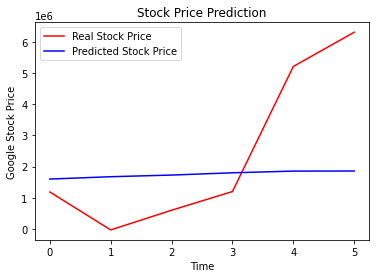

In [15]:
plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [16]:
df_12_m_past=df.iloc[-12:,:]
df_12_m_past.head(12)

,revenue,copper_index,ironore_index,lead_index,nickel_index,uranium_index,zinc_index,gold_index,platinum_index,palladium_index,silver_index,commodity_index
date,,,,,,,,,,,,
2021-01-01,433407.20440000,0.83303292,0.91351422,0.77927585,0.69594930,0.45213367,1.14629330,1.37196730,0.60923680,2.99022006,0.90969389,1.09833905
2021-02-01,810515.24800000,0.88606943,0.88933603,0.80530875,0.72658412,0.43586795,1.16236058,1.32920746,0.67684356,2.95689013,0.95816670,1.10594935
2021-03-01,622656.71890000,0.94103177,0.91351989,0.75416200,0.64144292,0.43097665,1.17938000,1.26548442,0.66102657,3.12677905,0.89941831,1.09946837
2021-04-01,67416.47699000,0.97439290,0.97658492,0.77643121,0.64466566,0.44284462,1.19720103,1.29313478,0.67600259,3.49401180,0.90087868,1.12972552
2021-05-01,541788.78770000,1.06746682,1.11140099,0.84412164,0.68827527,0.45863360,1.25479151,1.36185036,0.67865921,3.62246737,0.96635549,1.20171440
2021-06-01,168359.74980000,1.01050078,1.17655883,0.84824975,0.70293801,0.47875641,1.24790049,1.34670851,0.62841237,3.42912947,0.94537714,1.18394957
2021-07-01,1186474.86900000,1.00210305,1.17431753,0.90496076,0.73573783,0.48206097,1.24413659,1.32741317,0.60839815,3.43743649,0.90250346,1.17717319
2021-08-01,-30155.84982000,0.98830042,0.88805351,0.93528614,0.74817669,0.47946453,1.25779995,1.31308687,0.56466689,3.18609892,0.84142871,1.15230170
2021-09-01,600915.81560000,0.99260333,0.70865360,0.89633402,0.77148211,0.62930838,1.28021662,1.31961326,0.54644029,2.78751318,0.83801370,1.14694711


In [17]:
df_12_m_future=pd.read_csv("data-multiple.csv",parse_dates=["date"],index_col=[0])
df_12_m_future

,revenue,copper_index,ironore_index,lead_index,nickel_index,uranium_index,zinc_index,gold_index,platinum_index,palladium_index,silver_index,commodity_index
date,,,,,,,,,,,,
2017-01-01,1252216.06900000,0.59973271,0.44278159,0.86394432,0.38983604,0.33916914,1.14686175,0.87787057,0.54352195,0.94126477,0.59236907,0.81191732
2017-03-01,3008748.23100000,0.62133725,0.48733368,0.89488966,0.41611572,0.37318444,1.19529376,0.90783455,0.56465662,0.97365971,0.62881973,0.84598025
2017-04-01,489400.00000000,0.60793611,0.47772207,0.88305223,0.39896656,0.37062960,1.17412125,0.90489678,0.53706105,0.97787627,0.61808475,0.83335653
2017-07-01,1459550.00000000,0.59531388,0.38570310,0.86044328,0.37602520,0.34429174,1.10821103,0.93404949,0.53782945,1.00667063,0.63327735,0.81337647
2017-08-01,2140161.00000000,0.58726640,0.33765696,0.82505176,0.35816044,0.32081198,1.09404977,0.91599117,0.52125485,0.99807967,0.58924898,0.79628014
2017-09-01,2588701.00000000,0.59849116,0.31701966,0.82575758,0.34920056,0.29529586,1.08621035,0.92667281,0.52113940,1.08584263,0.59445958,0.79892030
2017-10-01,4721966.00000000,0.62736972,0.36564049,0.87876777,0.37108019,0.30344955,1.17240206,0.90945699,0.51390123,1.07779934,0.56791395,0.82901733
2017-11-01,2485377.91000000,0.68091339,0.40864234,0.90838930,0.42667110,0.30363824,1.25791686,0.94382340,0.54460555,1.14911366,0.59418920,0.88483448
2017-12-01,4441429.73000000,0.68698252,0.37933733,0.91923843,0.43849791,0.30408012,1.30378651,0.96665553,0.54065991,1.17757450,0.61177425,0.90612918


In [18]:
df_12_m_future["revenue"]=0
df_12_m_future=df_12_m_future[['revenue','copper_index','ironore_index','lead_index','nickel_index','uranium_index','zinc_index','gold_index','platinum_index','palladium_index','silver_index','commodity_index']]
old_scaled_array=scaler.transform(df_12_m_past)
new_scaled_array=scaler.transform(df_12_m_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.07681093,1.06264986,1.14362028,0.40539445,1.01649599,0.75624981,0.54442755,0.86538360,1.21959064,0.91273547,0.90885665,1.01829466
1,0.13819292,1.24840227,1.09726501,0.47592345,1.10630216,0.67781881,0.56994499,0.79049206,1.66118342,0.89788819,1.01746835,1.04395035
2,0.10761513,1.44089959,1.14363115,0.33735534,0.85671021,0.65423362,0.59697459,0.67888462,1.55787024,0.97356756,0.88583243,1.02210178
3,0.01723851,1.55774196,1.26454164,0.39768767,0.86615770,0.71145930,0.62527726,0.72731272,1.65569033,1.13715647,0.88910464,1.12410405
4,0.09445223,1.88371937,1.52301574,0.58107633,0.99399954,0.78759156,0.71674028,0.84766432,1.67304282,1.19437878,1.03581673,1.36679146
...,...,...,...,...,...,...,...,...,...,...,...,...
59,NaN,1.60645096,1.09480611,0.82806155,1.16960090,0.88803534,0.72151818,0.76225773,0.92846966,0.99999242,0.75589673,1.20021239
60,NaN,1.62152124,0.75085431,0.72253146,1.23792090,1.61056127,0.75711948,0.77368834,0.80941748,0.82243689,0.74824480,1.18216113
61,NaN,1.73251807,0.59465981,0.75357964,1.19547147,1.81744036,0.95359816,0.74956312,0.96787634,0.71415410,0.71026536,1.27975028
62,NaN,1.66710705,0.34902018,0.73799860,1.26085399,1.90489219,0.90139854,0.80313171,1.00542840,0.70125629,0.76963703,1.24649160


In [19]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=6
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In [20]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,12, axis=-1)
y_pred_future_6_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),12)))[:,0]
print(y_pred_future_6_days)

[1600723.   1676280.2  1731051.8  1805153.2  1861231.8  1867370.6
 1865330.1  1773566.4  1750111.8  1732481.8  1657504.2  1545958.1
 1369040.5  1315591.   1248056.5  1228846.4  1306001.4  1426417.9
 1548755.6  1622733.2  1615572.2  1568085.   1432411.1  1322250.2
 1244924.5  1167705.8  1168275.8  1174418.1  1189694.9  1205916.6
 1190481.2  1172845.2  1157522.6  1169055.1  1162030.1  1115701.2
 1060862.    942575.7   803288.2   688755.94  603715.7   528142.5
  549172.3   666136.9   787202.2   897590.94 1016530.5  1140623.8
 1225736.2  1321518.1  1443099.1  1543841.1  1611491.4  1687159.1
 1741516.6  1814129.2  1866639.4  1870311.9 ]


In [26]:
import plotly.express as px
import plotly.graph_objects as go

lstm_forecast_index=pd.date_range(start='2022-01-01',periods=11,freq='MS')

actual = go.Scatter(
    x = df.index,
    y =df.revenue,
    mode = 'lines',
    name = 'Actual'
)

predicted = go.Scatter(
    x = lstm_forecast_index,
    y = y_pred_future_6_days,
    mode = 'lines',
    name = 'Predict'
)

fig = go.Figure(data=[actual,predicted])
fig.show()